In [1]:
import datamol as dm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel

from mood.dataset import dataset_iterator, load_data_from_tdc
from mood.model_space import ModelSpaceTransformer
from mood.preprocessing import standardize_smiles
from mood.distance import compute_knn_distance
from mood.visualize import plot_distance_distributions
from mood.representations import representation_iterator, featurize
from mood.constants import DOWNSTREAM_APPS_DATA_DIR
from mood.utils import load_representation_for_downstream_application

In [2]:
def get_model_space_distances(model, train, queries):
    trans = ModelSpaceTransformer(model)

    model_space_train = trans(train)
    queries = [trans(q) for q in queries]

    distances = compute_knn_distance(
        model_space_train, 
        queries, 
        n_jobs=-1
    )
    return distances

Found local copy...
Loading...
Done!


  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

/home/cas/Documents/repositories/mood_v2/notebooks/../mood/representations.py:101: RuntimeWarning: All-NaN slice encountered
  min_charge, max_charge = np.nanmin(atomic_charges), np.nanmax(atomic_charges)


  0%|          | 0/4200 [00:00<?, ?it/s]

[16:09:02] UFFTYPER: Unrecognized charge state for atom: 1
[16:09:06] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:08] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:09] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:16] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:22] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:24] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:27] UFFTYPER: Unrecognized charge state for atom: 2
[16:09:35] UFFTYPER: Unrecognized charge state for atom: 21
[16:09:39] UFFTYPER: Unrecognized charge state for atom: 1
[16:09:39] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:39] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:47] UFFTYPER: Unrecognized charge state for atom: 8
[16:09:53] UFFTYPER: Unrecognized charge state for atom: 4
[16:09:53] UFFTYPER: Unrecognized atom type: Se2+2 (8)
[16:09:53] UFFTYPER: Unrecognized atom type: Se2+2 (8)
[16:10:02] UFFTYPER: Unrecognized charge state for atom: 5
[16:

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

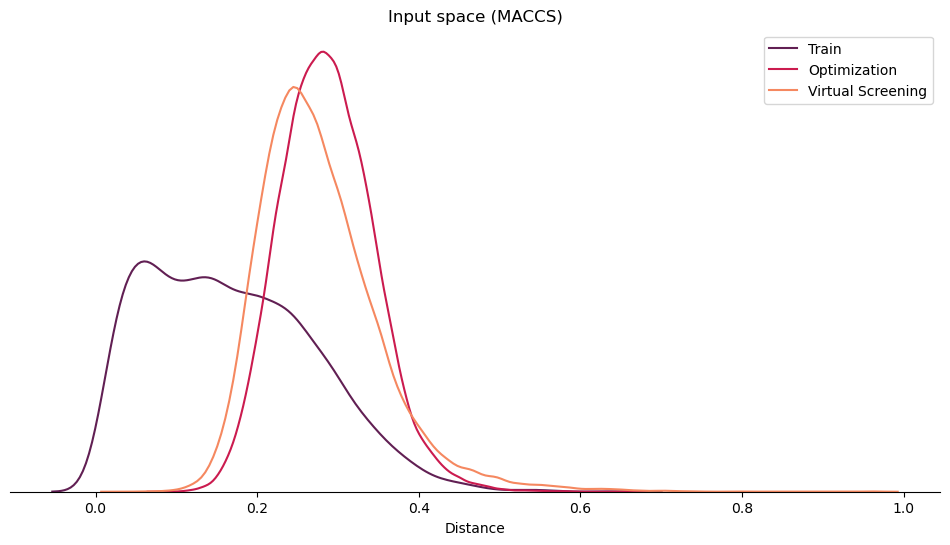

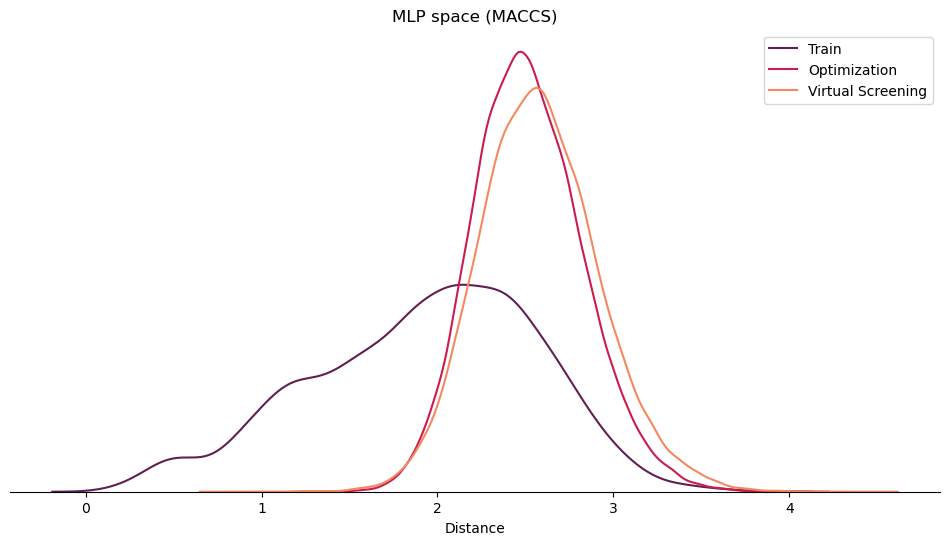

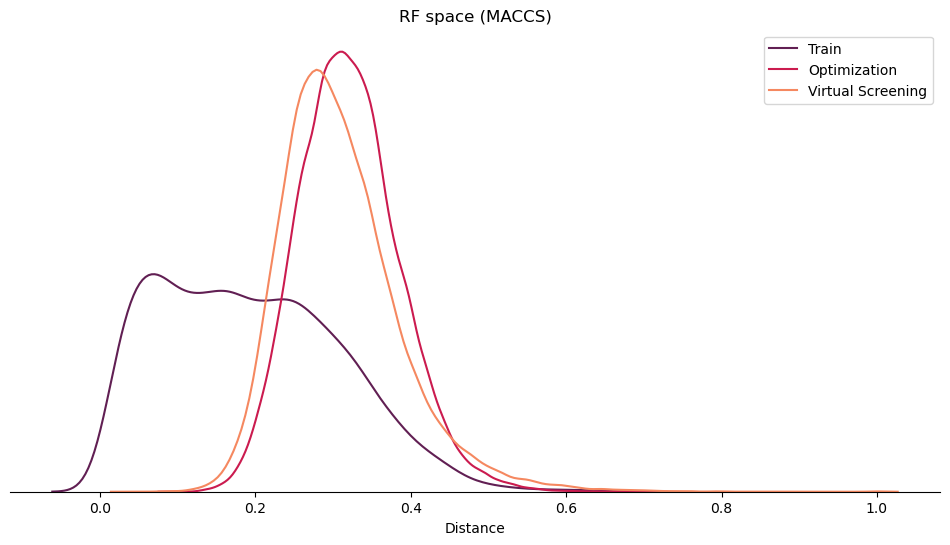

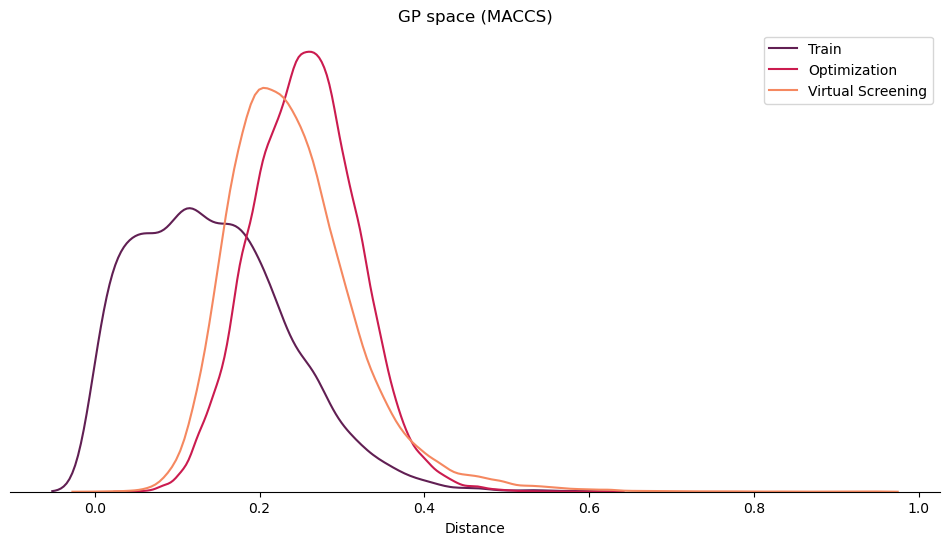

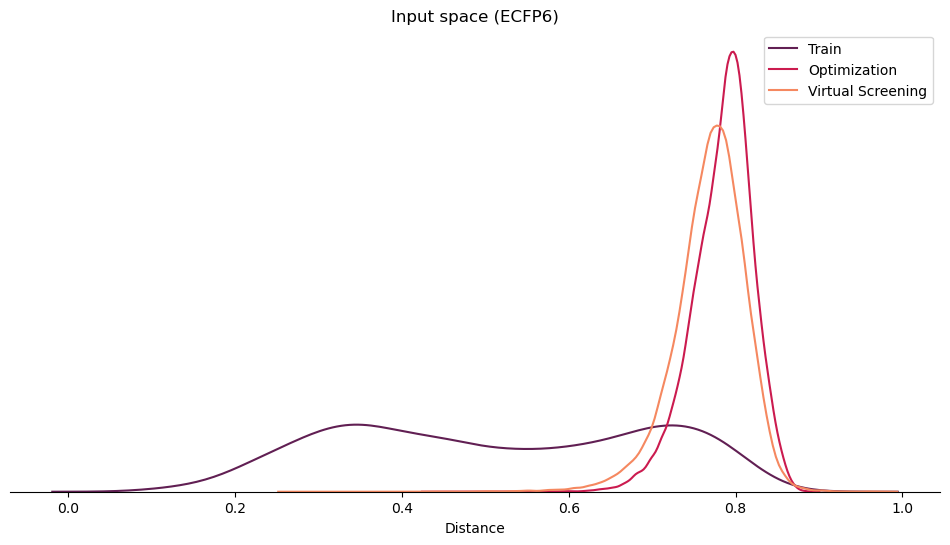

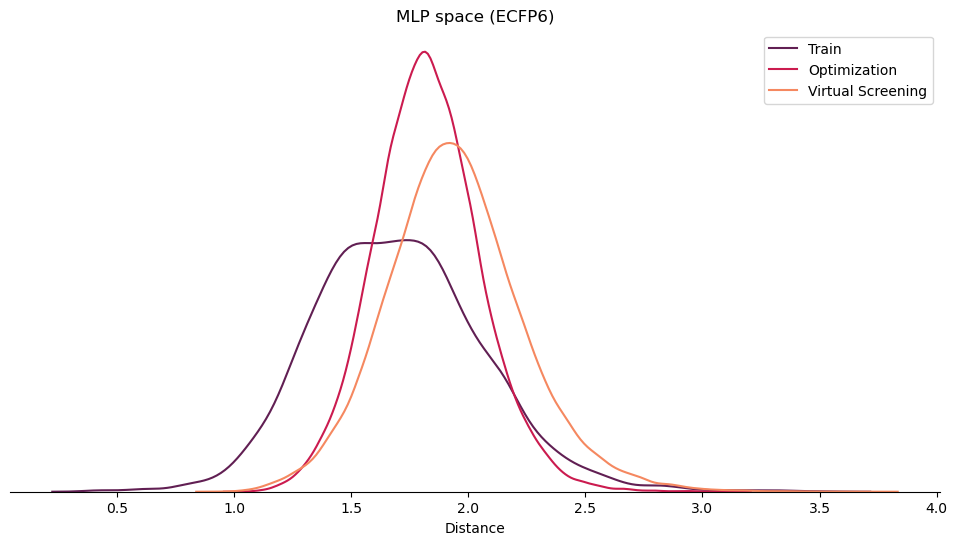

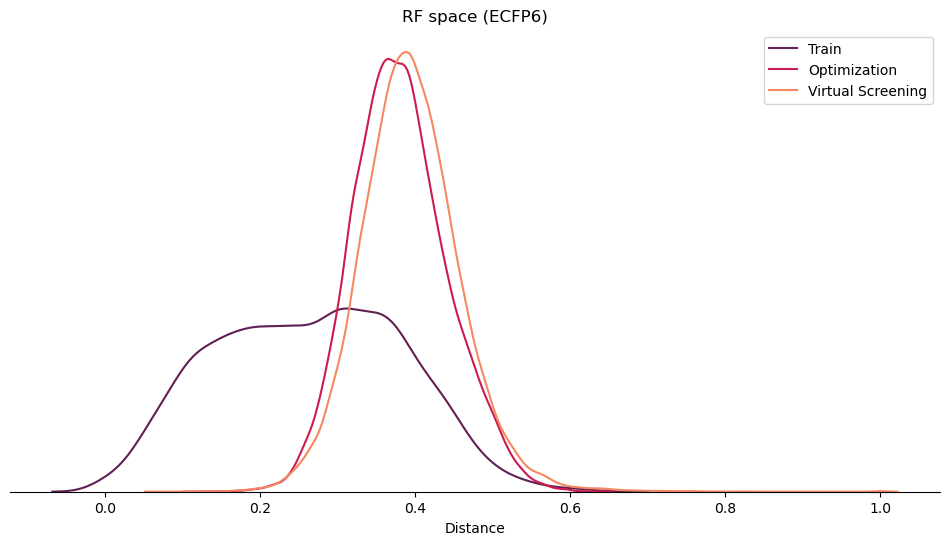

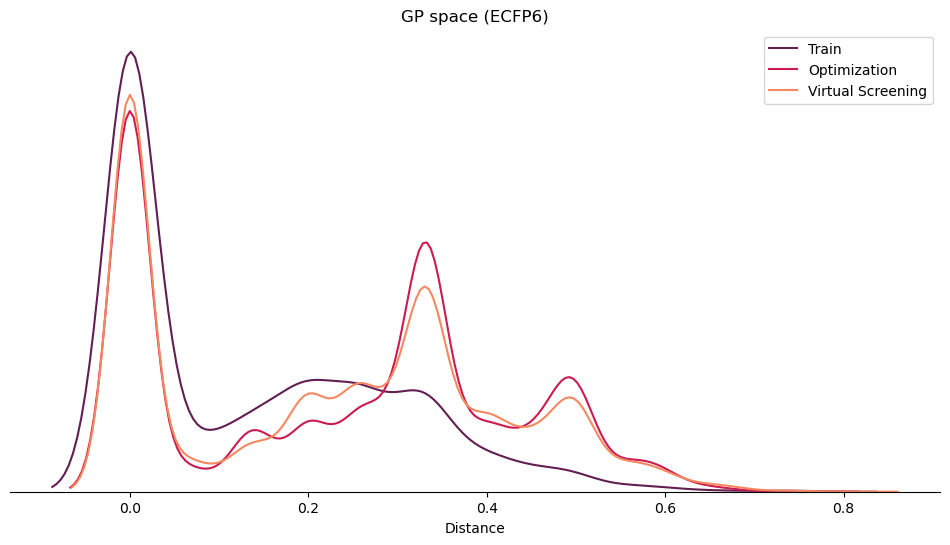

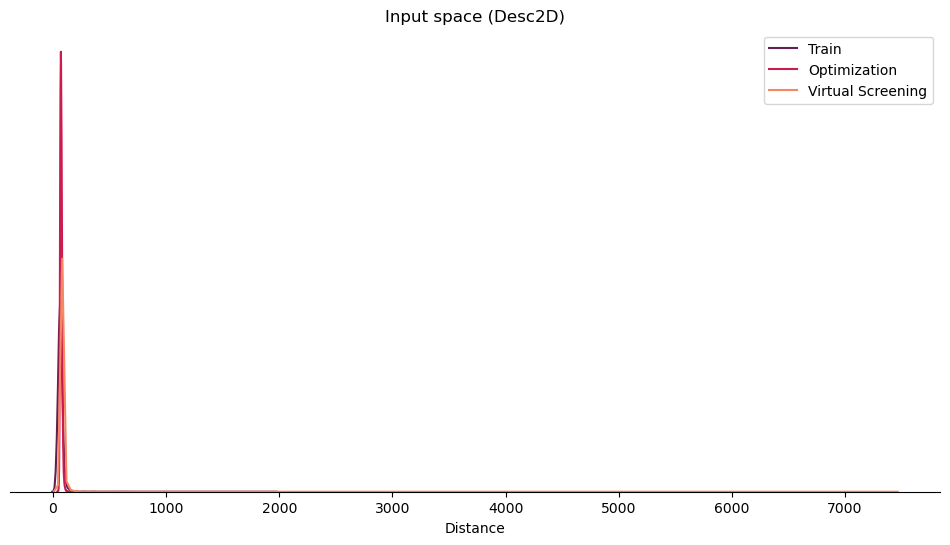

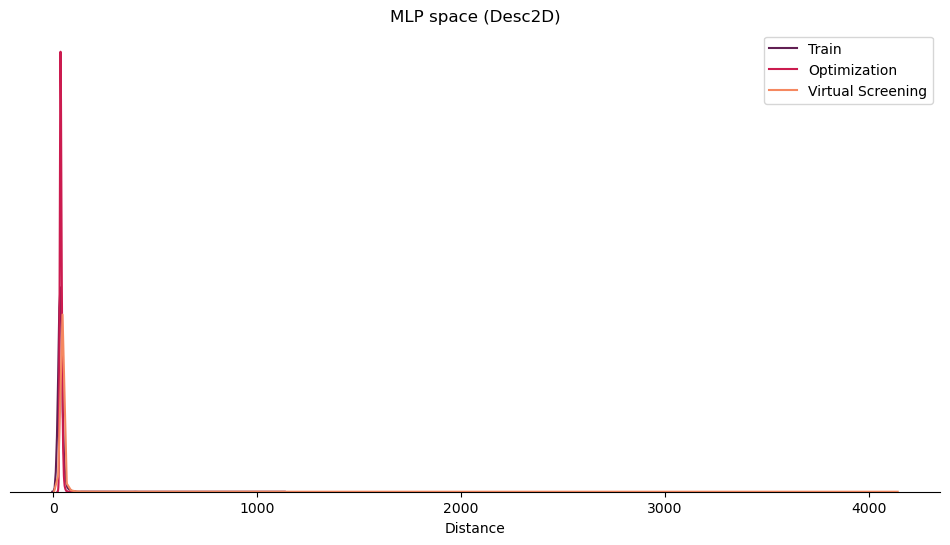

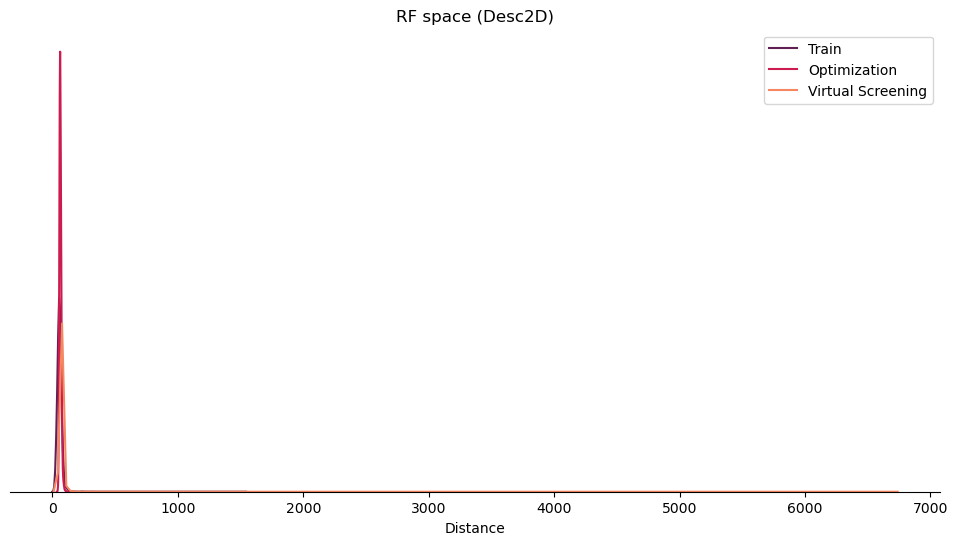

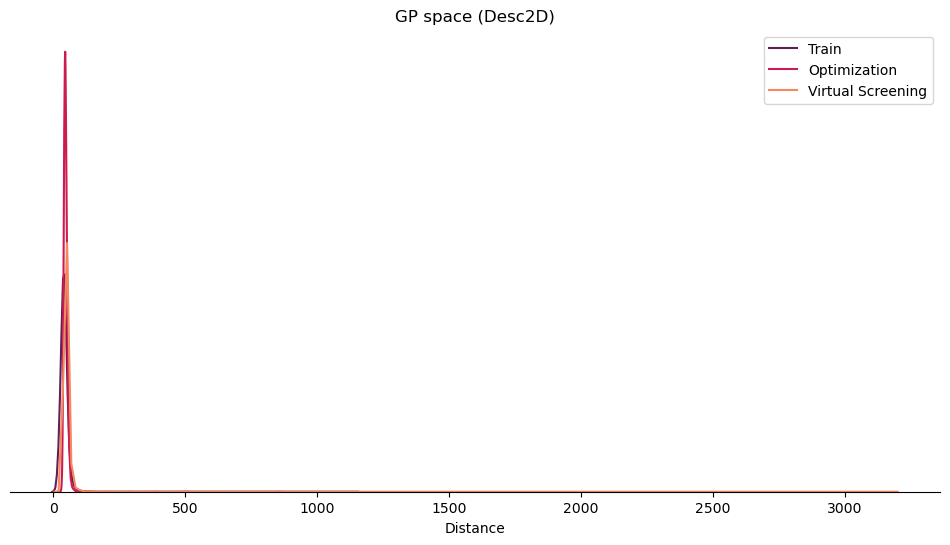

In [3]:
smiles, y = load_data_from_tdc("Lipophilicity", standardize_smiles)

for representation, X in representation_iterator(smiles, n_jobs=-1, progress=True):
    
    # TODO: Move removal of NaNs to generator?
    mask = [i for i, x in enumerate(X) if x is not None]
    X = X[mask]
    y = y[mask]
    
    mask = ~np.isnan(X).any(axis=1)
    X = X[mask]
    y = y[mask]
    
    virtual_screening = load_representation_for_downstream_application("virtual_screening", representation)
    optimization = load_representation_for_downstream_application("optimization", representation)
        
    mlp_model = MLPRegressor(random_state=0)
    mlp_model.fit(X, y)

    rf_model = RandomForestRegressor(random_state=0)
    rf_model.fit(X, y)
    
    kernel = PairwiseKernel(metric="linear")
    gp_model = GaussianProcessRegressor(kernel, alpha=1e-5, random_state=0)
    gp_model.fit(X, y)
    
    input_distances = compute_knn_distance(X, [X, optimization, virtual_screening], n_jobs=-1)
    mlp_distances = get_model_space_distances(mlp_model, X, [X, optimization, virtual_screening])
    rf_distances = get_model_space_distances(rf_model, X, [X, optimization, virtual_screening])
    gp_distances = get_model_space_distances(gp_model, X, [X, optimization, virtual_screening])
    
    labels = ["Train", "Optimization", "Virtual Screening"]
    ax = plot_distance_distributions(input_distances, labels=labels)
    ax.set_title(f"Input space ({representation})")
    
    ax = plot_distance_distributions(mlp_distances, labels=labels)
    ax.set_title(f"MLP space ({representation})")
    
    ax = plot_distance_distributions(rf_distances, labels=labels)
    ax.set_title(f"RF space ({representation})")
    
    ax = plot_distance_distributions(gp_distances, labels=labels)
    ax.set_title(f"GP space ({representation})")


The End.